In [1]:
import warnings
warnings.filterwarnings("ignore")

# import librosa
import torchaudio as ta
ta.set_audio_backend("sox_io")
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd.profiler as profiler
# import pytorch_lightning as pl

import numpy as np
import os

import IPython.display as ipd

import numpy as np

import math

import glob

from tqdm.auto import tqdm

from python_files.Noise_Reduction_Datagen_paths import Signal_Synthesis_DataGen
# from python_files.unet_basic import Model

import warnings

warnings.filterwarnings("ignore")

import gc

from random import shuffle
import random

# from numba import jit

In [2]:
ta.list_audio_backends()

['sox', 'sox_io']

In [3]:
random.seed(100)

In [4]:
from tqdm.auto import tqdm

In [5]:
from fastai.text.all import *
from fastai.data.core import DataLoaders
from fastai.callback.tensorboard import TensorBoardCallback

In [6]:
import fastai

fastai.__version__

'2.2.8'

In [7]:
torch.backends.cudnn.version()

8101

In [8]:
torch.backends.cudnn.benchmark = True

torch.__version__

'1.8.0a0+56b43f4'

In [9]:
torch.cuda.is_available()

True

In [10]:
torch.cuda.get_device_name()

'GeForce RTX 3090'

In [11]:
def get_paths(dir_path):
    paths = []
    for root, dirs, files in os.walk(dir_path):
        for name in files:
            if name.endswith(".wav") or name.endswith(".mp3"):
                paths.append(os.path.join(root, name))
                
    paths = np.asarray(paths)
    return paths

In [12]:
np_paths = np.load("./dataset_loader_files/signal_paths_nums_save.npy")

In [13]:
noise_paths_sh = get_paths("./dataset/Reduced_noise/")
shuffle(noise_paths_sh)

signal_paths_sh = get_paths("./dataset/Reduced_clean_signals/")
shuffle(signal_paths_sh)

In [14]:
noise_paths_sh.shape

(1741,)

In [15]:
(51855 * 104 )/ 500

10785.84

In [16]:
signal_paths_sh[-500:].shape

(500,)

In [17]:
np_paths = np.load("./dataset_loader_files/signal_paths_nums_save.npy")

In [18]:
noise_paths = noise_paths_sh[0:150]
signal_paths = signal_paths_sh[:150]
signal_dir = ""#"./dataset/cv-corpus-5.1-2020-06-22-Resampled/en/clips"
noise_save_path = ""#"./dataset_loader_files/noise_paths_resampled_save.npy"
train = True
n_fft=1024
win_length=n_fft
hop_len=n_fft//4
create_specgram = False
perform_stft = False
normalize = True
default_sr = 16000
sec = (16384/default_sr)*8
augment=True
device_datagen = "cpu"

train_ds = Signal_Synthesis_DataGen(noise_paths, signal_paths, signal_dir, \
                 n_fft=n_fft, win_length=win_length, hop_len=hop_len, create_specgram=create_specgram, \
                 perform_stft=perform_stft, normalize=normalize, default_sr=default_sr, sec=sec, epsilon=1e-5, augment=False, device=device_datagen)

150 ./dataset/Reduced_clean_signals/common_voice_en_19355404.mp3


In [19]:
noise_paths = noise_paths_sh[100:150]
signal_paths = signal_paths_sh[1000:1050]
signal_dir = ""#"./dataset/cv-corpus-5.1-2020-06-22-Resampled/en/clips"
noise_save_path = ""#"./dataset_loader_files/noise_paths_resampled_save.npy"
train = False

val_ds = Signal_Synthesis_DataGen(noise_paths, signal_paths, signal_dir,\
                 n_fft=n_fft, win_length=win_length, hop_len=hop_len, create_specgram=create_specgram, \
                 perform_stft=perform_stft, normalize=normalize, default_sr=default_sr, sec=sec, epsilon=1e-5, augment=False, device=device_datagen)

50 ./dataset/Reduced_clean_signals/common_voice_en_19670366.mp3


In [27]:
train_ds.__getitem__(1)[0].min()

tensor(1.0000e-05)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 78
shuffle = True
num_workers = 12
pin_memory = True

# data_loader = DataLoader(signal_synthesis_dataset, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=num_workers)
# data_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=num_workers, pin_memory=pin_memory)

dls = DataLoaders.from_dsets(train_ds, val_ds, bs=BATCH_SIZE, num_workers=num_workers, pin_memory=pin_memory).to(device)

In [22]:
class Unsqueezer(nn.Module):
    def __init__(self):
        super(Unsqueezer, self).__init__()
        
    def forward(self, x):
        return x.usqueeze(dim=1)

In [23]:
dls.after_batch = Unsqueezer

In [24]:
%%time
# for data in dls.train:
#     print(data[0].max(), data[0].min())
#     break

CPU times: user 0 ns, sys: 1 µs, total: 1 µs
Wall time: 2.62 µs


In [25]:
data[1].min()

NameError: name 'data' is not defined

In [26]:
train_ds.__len__()

22500

In [28]:
class Negative_SNR_Loss(nn.Module):
    def __init__(self):
        super(Negative_SNR_Loss, self).__init__()
    
    def forward(self, sig_pred, sig_true):
        
        sig_true_sq = torch.square(sig_true)
        sig_pred_sq = torch.square(sig_true - sig_pred)

        sig_true_mean = torch.mean(sig_true_sq)
        sig_pred_mean = torch.mean(sig_pred_sq)

        snr = sig_true_mean / sig_pred_mean + 1e-7
        loss = -1*torch.log10(snr)

        return loss

In [29]:
class Mod_MSELoss(nn.Module):
    def __init__(self, mul_factor):
        super(Mod_MSELoss, self).__init__()
        self.loss_fn = nn.MSELoss(reduction="mean")
        self.mul_factor = mul_factor
        
        
    def forward(self, sig_pred, sig_true):
        loss = self.loss_fn(sig_pred, sig_true)
        loss = self.mul_factor*loss
        return loss

In [30]:
class DownSamplingLayer(nn.Module):
    def __init__(self, channel_in, channel_out, dilation=1, kernel_size=15, stride=1, padding=7):
        super(DownSamplingLayer, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(channel_in, channel_out, kernel_size=kernel_size,
                      stride=stride, padding=padding, dilation=dilation),
            nn.BatchNorm1d(channel_out),
#             nn.LeakyReLU(negative_slope=0.1)
            nn.ELU()
        )

    def forward(self, ipt):
        return self.main(ipt)

class UpSamplingLayer(nn.Module):
    def __init__(self, channel_in, channel_out, kernel_size=5, stride=1, padding=2):
        super(UpSamplingLayer, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(channel_in, channel_out, kernel_size=kernel_size,
                      stride=stride, padding=padding),
            nn.BatchNorm1d(channel_out),
#             nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.ELU()
        )

    def forward(self, ipt):
        return self.main(ipt)

class Model(nn.Module):
    def __init__(self, n_layers=12, channels_interval=24):
        super(Model, self).__init__()
        self.n_layers = n_layers
        self.channels_interval = channels_interval
        encoder_in_channels_list = [1] + [i * self.channels_interval for i in range(1, self.n_layers)]
        encoder_out_channels_list = [i * self.channels_interval for i in range(1, self.n_layers + 1)]
        self.sigmoid = nn.Sigmoid()

        #          1    => 2    => 3    => 4    => 5    => 6   => 7   => 8   => 9  => 10 => 11 =>12
        # 16384 => 8192 => 4096 => 2048 => 1024 => 512 => 256 => 128 => 64 => 32 => 16 =>  8 => 4
        self.encoder = nn.ModuleList()
        for i in range(self.n_layers):
            self.encoder.append(
                DownSamplingLayer(
                    channel_in=encoder_in_channels_list[i],
                    channel_out=encoder_out_channels_list[i]
                )
            )

        self.middle = nn.Sequential(
            nn.Conv1d(self.n_layers * self.channels_interval, self.n_layers * self.channels_interval, 15, stride=1,
                      padding=7),
            nn.BatchNorm1d(self.n_layers * self.channels_interval),
#             nn.LeakyReLU(negative_slope=0.1, inplace=True)
            nn.ELU(inplace=True)
        )

        decoder_in_channels_list = [(2 * i + 1) * self.channels_interval for i in range(1, self.n_layers)] + [
            2 * self.n_layers * self.channels_interval]
        decoder_in_channels_list = decoder_in_channels_list[::-1]
        decoder_out_channels_list = encoder_out_channels_list[::-1]
        self.decoder = nn.ModuleList()
        for i in range(self.n_layers):
            self.decoder.append(
                UpSamplingLayer(
                    channel_in=decoder_in_channels_list[i],
                    channel_out=decoder_out_channels_list[i]
                )
            )

        self.out = nn.Sequential(
            nn.Conv1d(1 + self.channels_interval, 1, kernel_size=1, stride=1),
            nn.Sigmoid()
        )

    def forward(self, input):
        tmp = []
        o = input

        # Up Sampling
        for i in range(self.n_layers):
            o = self.encoder[i](o)
#             print(o.shape)
            tmp.append(o)
            # [batch_size, T // 2, channels]
            o = o[:, :, ::2]

        o = self.middle(o)

        # Down Sampling
        for i in range(self.n_layers):
            # [batch_size, T * 2, channels]
            o = F.interpolate(o, scale_factor=2, mode="linear", align_corners=True)
            # Skip Connection
            # print(o.shape, len(tmp))
            o = torch.cat([o, tmp[self.n_layers - i -1]], dim=1)
            o = self.decoder[i](o)
        o = torch.cat([o, input], dim=1)
        o = self.out(o)
#         o = torch.mul(o, input)
#         o = self.sigmoid(o)
        return o


In [31]:
use_scripted_model = False
w_decay = 1e-4

if not use_scripted_model:
    print("Using Primary model")
    model = Model(12, 24)#NoiseReducer(default_sr=default_sr, n_fft=n_fft, win_length=win_length, hop_len=hop_len, sec=sec).to(device)
    model.to(device)
else:
    print("Using Scripted Model")
    model = torch.jit.script(Model())

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0)
criterion = Mod_MSELoss(mul_factor=1000)
n_epochs=100


model.train()
scaler = torch.cuda.amp.GradScaler()

Using Primary model


In [32]:
learn = Learner(dls, model, loss_func=criterion, model_dir="./Model_saves/", \
                cbs=[ShowGraphCallback(), SaveModelCallback(monitor='valid_loss', fname='bestmodel', every_epoch=False)]).to_fp16()

In [33]:
# learn.load("bestmodel_1")

In [34]:
'GeForce RTX 3090'
learn.summary()

Model (Input shape: 78)
Layer (type)         Output Shape         Param #    Trainable 
                     78 x 24 x 131072    
Conv1d                                    384        True      
BatchNorm1d                               48         True      
ELU                                                            
____________________________________________________________________________
                     78 x 48 x 65536     
Conv1d                                    17328      True      
BatchNorm1d                               96         True      
ELU                                                            
____________________________________________________________________________
                     78 x 72 x 32768     
Conv1d                                    51912      True      
BatchNorm1d                               144        True      
ELU                                                            
________________________________________________________

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=1.0964781722577754e-06)

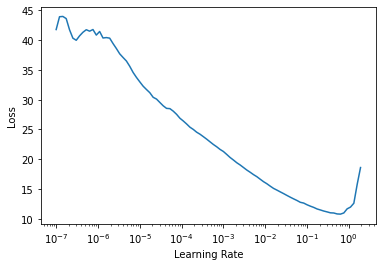

In [36]:
learn.lr_find()

In [35]:
learn.lr = 0.005120108485221863 #0.33113112449646 #0.06309573650360108 #0.0015848932266235352 #0.13182567358016967#0.03019951581954956#0.002290867641568184#0.19054607152938843

In [36]:
# learn.load("bestmodel_1")

In [ ]:
learn.fit_one_cycle(300)

epoch,train_loss,valid_loss,time


In [ ]:
# torch.save(learn.model.state_dict(), "./Model_saves/torch-best-1.pt")

In [ ]:
# learn.save("cnn_model_best_1_80")

In [ ]:
# checkpoint = pl.callbacks.ModelCheckpoint(dirpath="Model_saves/", monitor="val_loss", mode="min", verbose=True, filename="lightnng_save_lstm.pt")

# trainer = pl.Trainer(gpus=[0],max_epochs=20, \
#                     precision=16, \
#                     amp_backend="native",\
#                     num_sanity_val_steps=10, \
#                     benchmark=True, reload_dataloaders_every_epoch=True, \
#                     weights_save_path="./Model_saves/", weights_summary="top", \
#                     profiler="simple",  callbacks=[checkpoint])


# lr_finder = trainer.tuner.lr_find(model, dls.train, dls.valid)

# fig = lr_finder.plot(suggest=True); fig.show()

# lr_finder.suggestion()

# trainer.fit(model, dls.train, dls.valid)x

In [ ]:
learn.load("bestmodel")

In [ ]:
model = learn.model.eval()

In [ ]:
# fake_inputs = torch.randn(BATCH_SIZE, int(default_sr*sec)).type(torch.float32).to(device)
# outs = model(fake_inputs)
# outs.shape

In [ ]:
model.load_state_dict(torch.load("./Model_saves/Pytorch_model_2_save_LSTM_512_filters.pt"))

In [ ]:
scaler = torch.cuda.amp.GradScaler()

for epoch in range(1, n_epochs+1):
    
    loop = tqdm(enumerate(data_loader), leave=True, total=len(data_loader))
    train_loss = np.zeros((len(data_loader)))
    loop.set_description(f"Epoch: [ {epoch}/{n_epochs} ]\t")

    
    for index, (data, target) in loop:
        
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad(set_to_none=True)
        
        with torch.cuda.amp.autocast():
            output = model(data)
            loss = criterion(output, target)
            
        scaler.scale(loss).backward()
        for group in optimizer.param_groups:
            for param in group["params"]:
                param.data = param.data.add(-w_decay * group["lr"], param.data)
        scaler.step(optimizer)
        scaler.update()
        
#         output = model(data)
#         loss = criterion(output, target)
        
#         loss.backward()
#         for group in optimizer.param_groups:
#             for param in group["params"]:
#                 param.data = param.data.add(-w_decay * group["lr"], param.data)
#         optimizer.step()

        train_loss[index] = loss.item()
        if np.isnan(loss.item()) or np.isnan(np.sum(train_loss)/index+1e-5):
            print(f"Data shape = {data.shape}\nTarget Shape = {target.shape}, \nindex = {index}")
        disp_loss = np.sum(train_loss)/index+1e-5
        loop.set_postfix(loss = disp_loss)

In [ ]:
# torch.save(learn.model.state_dict(), "./Model_saves/torch_model_save_latge_dataset.pt")

In [ ]:
model = Model()
model.load_state_dict(torch.load("./Model_saves/torch-best-1.pt"))
device = "cpu"
model.to(device)
# torch.save(model.state_dict(), "./Model_saves/torch_model_save_latge_dataset_cpu.pt")

In [ ]:
%%time
noise_add_sig, main_sig = val_ds.__getitem__(346)
noise_add_sig = torch.unsqueeze(noise_add_sig, dim=0).to(device)
main_sig = torch.unsqueeze(main_sig, dim=0).to(device)

with torch.no_grad():
    outs = model(noise_add_sig).squeeze()

outs.shape

x = outs.t().to("cpu").numpy()
ipd.Audio(x, rate=default_sr)

In [ ]:
outs.squeeze().t().to("cpu").numpy().shape

In [ ]:
x = noise_add_sig.squeeze().t().to("cpu").numpy()
ipd.Audio(x, rate=default_sr)

In [ ]:
x = main_sig.squeeze().t().to("cpu").numpy()
ipd.Audio(x, rate=default_sr)

In [ ]:
noise_add_sig.mean()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
axes[0].plot(main_sig.squeeze().t().to(device).numpy())
axes[1].plot(noise_add_sig.squeeze().t().to(device).numpy())
axes[2].plot(outs.t().squeeze().to(device).numpy())

axes[0].title.set_text("Main Signal")
axes[1].title.set_text("Noised speech Signal")
axes[2].title.set_text("Predicted Signal")

fig.show()

In [ ]:
fig.savefig("Audio_Signals_Plot.png")